In [40]:
# import libraries
%pylab inline
#%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import stats
from tqdm.autonotebook import tqdm

Populating the interactive namespace from numpy and matplotlib


Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования $\hat{y}_{T+1|T}$ , другая для $\hat{y}_{T+2|T}$ 

In [8]:
# Open data
data = pd.read_csv('NYC_2014-2016.csv', index_col=0)
data_may = data.iloc[:-720]
data_may

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2014-01-01 00:00:00,87,146,70,113,367,645,589,799,948,321,...,9,0,5,89,10,35,9,106,22,71
2014-01-01 01:00:00,92,184,93,153,539,604,490,635,667,225,...,24,0,3,22,2,5,0,87,0,44
2014-01-01 02:00:00,108,165,55,151,443,571,465,499,455,124,...,27,0,3,23,1,1,0,39,0,1
2014-01-01 03:00:00,77,108,32,112,372,533,442,370,307,101,...,57,0,0,3,2,1,0,5,1,0
2014-01-01 04:00:00,47,79,22,77,213,383,296,319,261,87,...,38,0,1,9,1,8,0,29,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,106,167,171,88,293,401,433,284,428,222,...,1,5,9,347,304,104,15,172,17,103
2016-05-31 20:00:00,99,166,165,65,301,350,404,351,444,190,...,0,16,10,336,271,154,23,284,116,111
2016-05-31 21:00:00,84,173,107,78,256,340,416,426,493,173,...,0,37,5,289,306,167,26,212,84,130
2016-05-31 22:00:00,83,98,127,94,174,345,415,411,490,144,...,1,20,9,392,299,123,12,222,53,123


### 1. Для каждой из шести задач прогнозирования $\hat{y}_{T+i|T}, i=1,\dots,6$ , сформируем выборки. Откликом будет $y_{T+i}$ y при всевозможных значениях T

### 2.  Разобьём каждую из шести выборок на три части:
- обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
- тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
- итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

### 3.  Выберем регрессионную модель и настроим её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. 
Желательно, чтобы модель:

- допускала попарные взаимодействия между признаками
- была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

### 4. Выбранными моделями построим для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд. Посчитаем в ноутбуке ошибку прогноза

In [9]:
# for regression
from pandas.tseries.holiday import *
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [10]:
def get_features(data):
    '''This function returen pandas Data Frame with new features. Input data must have column "y"'''
    data['diff'] = data['y'] - data['y'].shift(1)
    data['sum_24'] = data['y'].rolling(24).sum()
    data['sum_168'] = data['y'].rolling(168).sum()
    data['median_168'] = data['y'].rolling(168).median()
    data['week_max'] = data['y'].rolling(168).max()
    data['week_min'] = data['y'].rolling(168).min()
    data['diff_max_min'] = data['week_max'] - data['week_min']
    data['ma_24'] = data['y'].rolling(24).mean()
    data['ma_168'] = data['y'].rolling(168).mean()
    data['diff_ma'] = data['ma_168'] - data['ma_24']
    data['week_std'] = data['y'].rolling(168).std()
    # Add shift data
    for shift in [24, 48, 72, 168]:
        data['shift_{}'.format(shift)] = data['y'].shift(shift)

In [15]:
def get_season_fft(data):
    n = len(data)
    np_data = data['y'].values
    f_hat = np.fft.fft(np_data, n)                   # Compute FFT
    PSD = f_hat * np.conj(f_hat) / n                 # Power spectrum
    freq = np.arange(n)                              # x-axis
    L = np.arange(1, np.floor(n/2), dtype='int') 
    
    sortd = np.sort_complex(PSD)[::-1]
    # Use the PSD to filter out noise
    indeces = PSD > sortd[5]                          # Find all freqs with large power
    PSD_clean = PSD * indeces                         # Zero out all others
    fhat = indeces * f_hat                            # Zero out small Fourier coefs in Y
    inv_fft = np.fft.ifft(fhat)                       # Inverse FFT for filtered time signal

    indeces_bot = PSD > sortd[24]                     # Find all freqs with large power
    PSD_clean_bot = PSD * indeces_bot                 # Zero out all others
    fhat_bot = indeces_bot * f_hat                    # Zero out small Fourier coefs in Y
    inv_fft_bot = np.fft.ifft(fhat_bot)               # Inverse FFT for filtered time signal
    
    data['fft_5'] = np.abs(inv_fft)
    data['fft_24'] = np.abs(inv_fft_bot)

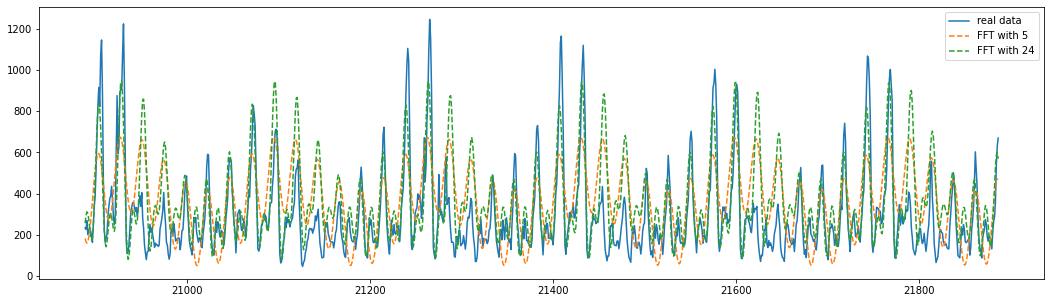

In [27]:
# Test seasonal fft
df_test = pd.DataFrame(data.iloc[:, 30].values, columns=['y'])
get_season_fft(df_test)

plt.figure(figsize=(18, 5))
plt.plot(df_test.iloc[-1000:, 0], label='real data')
plt.plot(df_test.iloc[-1000:, 1], '--', label='FFT with 5')
plt.plot(df_test.iloc[-1000:, 2], '--', label='FFT with 24')
plt.legend();

In [41]:
def get_predict(X_train, X_test, y_train):
    # Initialize models
    model_r = Ridge().fit(X_train, y_train)
    model_l = Lasso().fit(X_train, y_train)
    # Get predict
    pred_r = model_r.predict(X_test)
    pred_l = model_l.predict(X_test)
    # Change negative values to 0
    pred_r = np.where(pred_r>0, pred_r, 0)
    pred_l = np.where(pred_l>0, pred_l, 0)
    
    return pred_r, pred_l

In [12]:
# Create new df for date features
df_feats = pd.DataFrame(np.zeros((data_all.shape[0], 1)), columns=['holiday'])
df_feats.index = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')

# Add holidays to data
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2014, 1, 1), end=datetime(2016, 6, 30)) 
# Сonvert it to the needed format and substitute it in the data
h_days = pd.to_datetime(holidays).strftime('%Y-%m-%d')
for h in h_days:
    df_feats.holiday[h] = 1
    
# Add numbers of hours, weekday and weekends
df_feats["hour"] = df_feats.index.hour
df_feats["weekday"] = df_feats.index.weekday
df_feats["is_weekend"] = df_feats.weekday.isin([5, 6]) * 1
df_feats['day'] = df_feats.index.day
df_feats['week'] = df_feats.index.week
df_feats.sample(3)

,holiday,hour,weekday,is_weekend,day,week
2015-01-23 01:00:00,0.0,1,4,0,23,4
2016-05-02 07:00:00,0.0,7,0,0,2,18
2016-03-10 15:00:00,0.0,15,3,0,10,10


In [13]:
# Create constant and new regression features matrix for seasons and trands to all clusters regions
pi = np.math.pi
K = 10
reg_feature = np.zeros((len(data_all), K*4)) 
# Let's fill the array with features
for k in range(K):
    for i in range(len(reg_feature)):   
        # Week cicle
        reg_feature[i, k*4] = np.sin((i+1)*2*pi*(k+1)/168.)
        reg_feature[i, k*4+1] = np.cos((i+1)*2*pi*(k+1)/168.)
        # Year cicle
        reg_feature[i, k*4+2] = np.sin((i+1)*2*pi*(k+1)/8760)
        reg_feature[i, k*4+3] = np.cos((i+1)*2*pi*(k+1)/8760)

# Create Data Frame
cols = []
for k in range(10):
    cols.append('sin_week_{}'.format(k*4))
    cols.append('cos_week_{}'.format(k*4+1))
    cols.append('sin_year_{}'.format(k*4+2))
    cols.append('cos_year_{}'.format(k*4+3))
    
# Create Data Frame
reg_feature = pd.DataFrame(reg_feature, columns=cols)
reg_feature.index = pd.date_range(start='1/1/2014', end='7/1/2016', freq='H', closed='left')
reg_feature = pd.concat([reg_feature, df_feats], axis=1)
print(reg_feature.shape)
reg_feature.head(3)

(21888, 46)


,sin_week_0,cos_week_1,sin_year_2,cos_year_3,sin_week_4,cos_week_5,sin_year_6,cos_year_7,sin_week_8,cos_week_9,...,sin_week_36,cos_week_37,sin_year_38,cos_year_39,holiday,hour,weekday,is_weekend,day,week
2014-01-01 00:00:00,0.037391,0.999301,0.000717,1.000000,0.074730,0.997204,0.001435,0.999999,0.111964,0.993712,...,0.365341,0.930874,0.007173,0.999974,1.0,0,2,0,1,1
2014-01-01 01:00:00,0.074730,0.997204,0.001435,0.999999,0.149042,0.988831,0.002869,0.999996,0.222521,0.974928,...,0.680173,0.733052,0.014345,0.999897,1.0,1,2,0,1,1
2014-01-01 02:00:00,0.111964,0.993712,0.002152,0.999998,0.222521,0.974928,0.004304,0.999991,0.330279,0.943883,...,0.900969,0.433884,0.021516,0.999769,1.0,2,2,0,1,1


In [44]:
#
Qmay_l = 0
Qmay_r = 0

for reg in range(102):
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 05.31.2016 17:00
        reg_feats_may = reg_feature.iloc[:data_may.shape[0]-6, :]
        reg_feats_may['y'] = shifted_data.iloc[:reg_feats_may.shape[0], reg].values
        # Add new features: sum, median, max and min, moving average
        get_features(reg_feats_may)
        get_season_fft(reg_feats_may)
        
        # Split y to train and test
        y_train = reg_feats_may['y'].iloc[168:-739]
        y_test = reg_feats_may['y'].iloc[-739:]
        # Delete real values
        reg_feats_may.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_may[168:-739].values
        X_test = reg_feats_may[-739:].values
        
        # Get our predict
        pred_r, pred_l = get_predict(X_train, X_test, y_train)
        
        # Calculate errors
        Qmay_l += sum(abs(y_test.values - pred_l))
        Qmay_r += sum(abs(y_test.values - pred_r))

In [45]:
Qmay_l/739/6/102, Qmay_r/739/6/102

(23.45271012081134, 22.828983282928853)

### 5. Итоговыми моделями построить прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00
Запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [84]:
Qjune_l = 0
Qjune_r = 0
Qjune_norm_r = 0

predict_lasso = np.zeros((6, 715, 102))
predict_ridge = np.zeros((6, 715, 102))
predict_ridge_norm = np.zeros((6, 715, 102))

for region in range(102):
    region_name = data.columns[region]
#     # Create data for search the best parametr of regression
#     mini_data = pd.DataFrame(data[region_name].loc['2015-05-01 00:00:00':'2016-03-29'].values, columns=['y'])
#     # Add features
#     get_features(mini_data)
#     get_season_fft(mini_data)
    
#     y_grid = mini_data.y[168:].values
#     mini_data.drop('y', axis=1, inplace=True)
#     X_grid = mini_data[168:]
#     # Let's seach the best aplha for our regression
#     params = {'alpha': [0.1, 0.5, 1, 1.5, 2., 2.5]}
#     # Initilize selection of models
#     clf_r = GridSearchCV(Ridge(), params)
#     clf_r.fit(X_grid, y_grid)
#     clf_l = GridSearchCV(Lasso(), params)
#     clf_l.fit(X_grid, y_grid)

#     print(clf_r.best_params_, clf_l.best_params_)
    
    for lag in range(1, 7):
        # Create shifred data for y
        shifted_data = data.shift(-lag)
        # Change size for features to 01.01.2014 - 06.30.2016 17:00
        reg_feats_june = reg_feature.iloc[:data.shape[0]-6, :]
        reg_feats_june['y'] = shifted_data.iloc[:reg_feats_june.shape[0], region].values
        # Add new features: sum, median, max and min, moving average
        get_features(reg_feats_june)
        get_season_fft(reg_feats_june)
        
        # Split y to train and test
        y_train = reg_feats_june['y'].iloc[168:-715]
        y_test = reg_feats_june['y'].iloc[-715:]
        # Delete real values
        reg_feats_june.drop('y', axis=1, inplace=True)
        
        # Split exog to train and test
        X_train = reg_feats_june[168:-715].values
        X_test = reg_feats_june[-715:].values
        
        predict_ridge[lag-1, :, region], predict_lasso[lag-1, :, region] = get_predict(X_train, X_test, y_train)
        
        # When we'll use Ridge regression, input data should normalized 
        # because the Ridge regression will punish for too big errors.
        # Create scaler
        scaler = StandardScaler()
        # Convert sign
        standardized_signs = scaler.fit_transform(X_train)
        standardized_signs_june = scaler.fit_transform(X_test)
        # Fit our models and substitute our best alpha
        # ridge_norm = Ridge(clf_r.best_params_['alpha']).fit(standardized_signs, y_train)
        ridge_norm = Ridge().fit(standardized_signs, y_train)
        # Get predictions
        predict_ridge_norm[lag-1, :, region] = ridge_norm.predict(standardized_signs_june)
        
        # Calculate errors
        Qjune_l += sum(abs(y_test.values - predict_lasso[lag-1, :, region]))
        Qjune_r += sum(abs(y_test.values - predict_ridge[lag-1, :, region]))
        Qjune_norm_r += sum(abs(y_test.values - predict_ridge_norm[lag-1, :, region]))

In [85]:
Qjune_l/715/6/102, Qjune_r/715/6/102 , Qjune_norm_r/715/6/102

(22.24910869309277, 21.474755917029388, 30.494278691317604)

#### Предыдущая ошибка SARIMAX: 28.02240

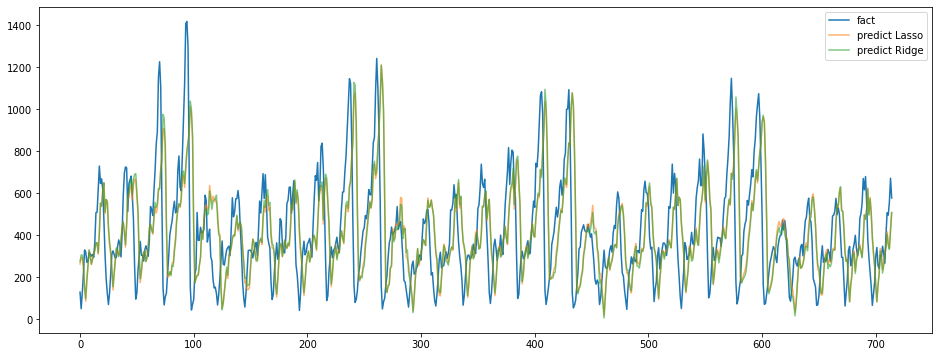

In [91]:
# NEW 
plt.figure(figsize=(16, 6))
plt.plot(data.iloc[-716:-1, 8].values, label='fact');
plt.plot(predict_lasso[0, :, 8], alpha=0.6, label='predict Lasso');
plt.plot(predict_ridge[0, :, 8], alpha=0.6, label='predict Ridge')
plt.legend();

In [92]:
# Change negative values to zero
for T in range(6):
    for region in range(102):
        for i in range(715):
            if predict_ridge[T, i, region] < 0:
                predict_ridge[T, i, region] = 0

In [93]:
# 714 + 1(23:00) * 6 * 102
per = pd.date_range(start='5/31/2016', end='7/1/2016', freq='H', closed='left')
period = per[23:-6]

In [94]:
# Let's write answer to needed format region_year-month-day_hour_T
kaggle_pred = []
for region in range(102):
    reg = data.columns[region]
    for i in range(715):
        for T in range(6):
            kaggle_pred.append([str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_'))+str(period[i].hour)+str('_')+str(T+1), 
                                predict_ridge[T, i, region]])
            #print(str(reg)+'_'+str(period[i].strftime('%Y-%m-%d_%H'))+str('_')+str(T+1), predict_ridge[T, i, region])
            
len(kaggle_pred)

437580

In [95]:
# Save 
kaggle = pd.DataFrame(kaggle_pred, columns=['id', 'y'])
indx_zero = kaggle.y[kaggle.y < 0].index
kaggle.y[indx_zero] = 0
kaggle['id'] = kaggle['id'].astype(str)
kaggle.to_csv('kaggle_june_new.csv', sep=',', index=False)
kaggle

,id,y
0,1075_2016-05-31_23_1,31.274523
1,1075_2016-05-31_23_2,20.368091
2,1075_2016-05-31_23_3,10.795133
3,1075_2016-05-31_23_4,8.559991
4,1075_2016-05-31_23_5,8.096174
...,...,...
437575,2168_2016-06-30_17_2,13.754254
437576,2168_2016-06-30_17_3,12.312646
437577,2168_2016-06-30_17_4,14.584775
437578,2168_2016-06-30_17_5,17.700935


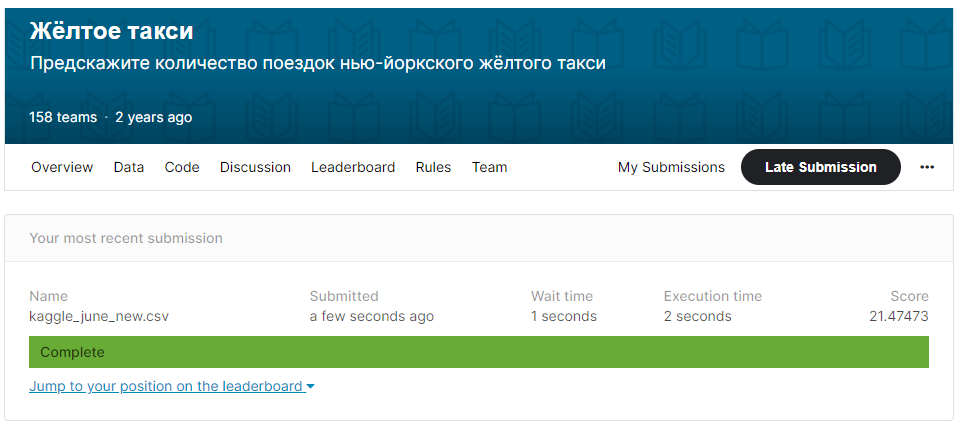

Буду продолжать улучшать, можно попробовать библиотеку от facebook - prophet